This is the code used for my BSc thesis in Harokopio University of Athens.

The sections denoted by **(*)** should **always** run.

# Preliminaries (*)
In this section, we:
* import the libraries used
* mount google drive
* create the agent class (in which we declare the movement etc)
* implement A*


In [1]:
import os
import sys
import time
import copy
import random
import functools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from IPython import get_ipython
from scipy.spatial.distance import cdist
from PIL import Image
import re

from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

def check_run_colab() -> bool:
    return bool('google.colab' in sys.modules)

Mount Google Drive:

In [2]:
# Check if the current environment is Google Colab
if check_run_colab():
    print("Running in Google Colab!")
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not running in Google Colab.")

Not running in Google Colab.


The Agent Class:

In [3]:
class Agent:

  def __init__(self, start: tuple, goal: tuple, real_stage, view_range=2):
      self.x = start[0]
      self.y = start[1]
      self.goal = goal
      self.view_range = view_range
      self.explored_stage = np.full_like(real_stage, -1)
      self.explored_stage[self.x, self.y] = 0
      self.agent_view(real_stage)
      self.start_time = time.time()
      # voronoi related parameters:
      self.voronoi_coords = None
      # self.broadcast_range = max(real_stage.shape[0], real_stage.shape[1]) *2 #// 4
      self.broadcast_range = max(real_stage.shape[0], real_stage.shape[1]) // 4


  def agent_view(self, real_stage):
    """ Refreshes the explored map of the agent (sees up, down, left, right). """
    up_obs, upleft_obs, upright_obs, down_obs, downleft_obs, downright_obs, left_obs, right_obs = False, False, False, False, False, False, False, False
    for i in range(self.view_range):
      if self.x > i:  # checks up
        tmp_x = self.x - i - 1
        if not up_obs:  # stops if it sees obstacle
          self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
          if real_stage[(tmp_x, self.y)]:
            up_obs = True
        if self.y > i and not upleft_obs:  # up-left
          if not upleft_obs:  # stops if it sees obstacle
            self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
            if real_stage[(tmp_x, self.y - i - 1)]:
              upleft_obs = True
        if self.y < len(real_stage[0]) - i - 1: # up-right
          if not upright_obs:  # stops if it sees obstacle
            self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]
            if real_stage[(tmp_x, self.y + i + 1)]:
              upright_obs = True

      if self.x < len(real_stage) - i - 1:  # checks down:
        tmp_x = self.x + i + 1
        if not down_obs:
          self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
          if real_stage[(tmp_x, self.y)]:
            down_obs = True
        if self.y > i:  # down-left
          if not downleft_obs:
            self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
            if real_stage[(tmp_x, self.y - i - 1)]:
              downleft_obs = True
        if self.y < len(real_stage[0]) - i - 1: # down-right
          if not downright_obs:
            self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]
            if real_stage[(tmp_x, self.y + i + 1)]:
              downright_obs = True

      if self.y > i and not left_obs:  # left (& stops if it sees obstacle)
        self.explored_stage[(self.x, self.y - i - 1)] = real_stage[(self.x, self.y - i - 1)]
        if real_stage[(self.x, self.y - i - 1)]:
          left_obs = True

      if self.y < len(real_stage[0]) - i - 1 and not right_obs: # right (& stops if it sees obstacle)
        self.explored_stage[(self.x, self.y + i + 1)] = real_stage[(self.x, self.y + i + 1)]
        if real_stage[(self.x, self.y + i + 1)]:
          right_obs = True

    self.explored_stage[self.explored_stage == 2] = 0

  def check_goal(self):
    if (self.x, self.y) == self.goal:
      return True
    return False

A* Algorithm (source [here](https://pypi.org/project/python-astar/)):

In [4]:
"""
Python-astar - A* path search algorithm
"""

class Tile:
    """A tile is a walkable space on a map."""
    distance = 0
    came_from = None

    def __init__(self, x, y, weight=1):
        self.x = x
        self.y = y
        self.weight = 1
        assert (self.x is not None and self.y is not None)

    def update_origin(self, came_from):
        """Update which tile this one came from."""
        self.came_from = came_from
        self.distance = came_from.distance + self.weight

    def __eq__(self, other):
        """A tile is the same if they have the same position"""
        return (other and self.x == other.x and self.y == other.y)

    def __lt__(self, other):
        """We want the shortest distance tile to find the happy path.
        This is used by min() so we can just compare them :)
        """
        return (self.distance + self.weight <= other.distance)

    def __hash__(self):
        """We need this so we can use a set()"""
        return hash(str(self))

    @property
    def pos(self):
        """a (x, y) tuple with position on the grid"""
        return (self.x, self.y)

    def __str__(self):
        return str(self.pos)

    def __repr__(self):
        return str(self)


class AStar:
    """The A Star (A*) path search algorithm"""

    def __init__(self, world, coverage_mode: bool = False):
        world2 = copy.deepcopy(world)
        world2[world2 == -1] = 0
        if coverage_mode: # coverage_mode == different goals.
          world2[world2 == 2] = 1 # astar takes agents into account.
        else:
          world2[world2 == 2] = 0
        self.world = world2

    def search(self, start_pos, target_pos):
        """A_Star (A*) path search algorithm"""
        start = Tile(*start_pos)
        self.open_tiles = set([start])
        self.closed_tiles = set()

        # while we still have tiles to search
        while len(self.open_tiles) > 0:
            # get the tile with the shortest distance
            tile = min(self.open_tiles)
            # check if we're there. Happy path!
            if tile.pos == target_pos:
                return self.rebuild_path(tile)
            # search new ways in the neighbor's tiles.
            self.search_for_tiles(tile)

            self.close_tile(tile)
        # if we got here, path is blocked :(
        return None

    def search_for_tiles(self, current):
        """Search for new tiles in the maze"""
        for other in self.get_neighbors(current):
            if self.is_new_tile(other):
                other.update_origin(current)
                self.open_tiles.add(other)

            # if this other has gone a farthest distance before
            #   then we just found a new and shortest way to it.
            elif other > current:
                other.update_origin(current)
                if other in self.closed_tiles:
                    self.reopen_tile(other)

    def get_neighbors(self, tile):
        """Return a list of available tiles around a given tile"""
        min_x = max(0, tile.x - 1)
        max_x = min(len(self.world)-1, tile.x + 1)
        min_y = max(0, tile.y - 1)
        max_y = min(len(self.world[tile.x])-1, tile.y + 1)

        available_tiles = [
            (min_x, tile.y),
            (max_x, tile.y),
            (tile.x, min_y),
            (tile.x, max_y),
        ]
        neighbors = []
        for x, y in available_tiles:
            if (x, y) == tile.pos:
                continue

            if self.world[x][y] == 0:
                neighbors.append(Tile(x, y))

        return neighbors

    def rebuild_path(self, current):
        """Rebuild the path from each tile"""
        self.last_tile = current
        path = []
        while current is not None:
            path.append(current)
            current = current.came_from
        path.reverse()
        # return a list with tuples
        return [tile.pos for tile in path]

    def is_new_tile(self, tile):
        """Check if this is a proviously unknown tile"""
        return (
            tile not in self.open_tiles
            and tile not in self.closed_tiles
        )

    def reopen_tile(self, tile):
        """Reinstate a tile in the open list"""
        self.closed_tiles.remove(tile)
        self.open_tiles.add(tile)

    def close_tile(self, tile):
        """Remove tile from open_tiles, as we are done testing it"""
        self.open_tiles.remove(tile)
        self.closed_tiles.add(tile)

# Stage/Maze (*)
This section contains code for:
* plot the stage/maze
* creation of gifs (that show the exploration process)
* simple stage creation
* maze creation
* agent generation (on stage)
* update of agent explored stage
* calculation of agent explored stage percentage
* checking the percentage difference of explored & real stage

Function to plot the grid/maze:

In [5]:
def draw_maze(maze, path=None, goal=None, save_gif=False):
    fig, ax = plt.subplots(figsize=(10,10))

    fig.patch.set_edgecolor('white')
    fig.patch.set_linewidth(0)

    ax.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')

    if path is not None:
        x_coords = [x[1] for x in path]
        y_coords = [y[0] for y in path]
        ax.plot(x_coords, y_coords, color='red', linewidth=2)
        ax.scatter(path[-1][1], path[-1][0], color='red', s=100, marker='s')

    if goal is not None:
        ax.scatter(goal[1], goal[0], color='red', s=100, marker='s')

    ax.set_xticks([])
    ax.set_yticks([])

    # Saves images to folder ========================
    if save_gif:
        if not os.path.exists("tmp_img"):
            os.makedirs("tmp_img")
        filepath = os.path.join("tmp_img", f"{time.time()}.png")
        plt.savefig(filepath)
    # =============================================

    plt.show()

In [6]:
from matplotlib.colors import ListedColormap, Normalize

def draw_maze_voronoi(v_map, agent_explored=None, path=None, goal=None, save_gif=False):
    unique_values = np.unique(v_map)
    # print(len(unique_values))
    if len(unique_values) > 11:
        print("Colored plot not supported for more than 10 agents. Plotting in grayscale:")
        draw_maze(v_map, path, goal, save_gif) if agent_explored is None else draw_maze(agent_explored, path, goal, save_gif)
        return

    tmp_v_map = copy.deepcopy(v_map)
    fig, ax = plt.subplots(figsize=(10,10))

    fig.patch.set_edgecolor('white')
    fig.patch.set_linewidth(0)

    if agent_explored is not None:
        tmp_v_map[agent_explored == 1] = -1  # obstacles -> gray
        tmp_v_map[agent_explored == -1] = -2    # unexplored areas -> white
        tmp_v_map[agent_explored == 2] = -3 # agents -> black
    color_dict = {-3: 'black', -2: 'white', -1: '#555555', 0: "blue", 1: "brown", 2: "green", 3: "purple", 4: "orange", 5: "cyan", 6: "magenta", 7: "yellow", 8: "lime", 9: "pink"}
    # else:
    #     color_dict = {-1: 'darkgray', 0: "blue", 1: "brown", 2: "green", 3: "purple", 4: "orange", 5: "cyan", 6: "magenta", 7: "yellow", 8: "lime", 9: "pink"}

    colors = [color_dict[val] for val in sorted(color_dict.keys())]
    cmap = ListedColormap(colors)

    norm = Normalize(vmin=min(color_dict.keys()), vmax=max(color_dict.keys()))

    plt.imshow(tmp_v_map, cmap=cmap, norm=norm, interpolation='nearest')
    # if agent_explored is None:
    #     plt.colorbar()

    if path is not None:
        x_coords = [x[1] for x in path]
        y_coords = [y[0] for y in path]
        ax.plot(x_coords, y_coords, color='red', linewidth=2)
        ax.scatter(path[-1][1], path[-1][0], color='red', s=100, marker='s')

    if goal is not None:
        ax.scatter(goal[1], goal[0], color='red', s=100, marker='s')

    ax.set_xticks([])
    ax.set_yticks([])

    # Saves images to folder ========================
    if save_gif:
        if not os.path.exists("tmp_img"):
            os.makedirs("tmp_img")
        filepath = os.path.join("tmp_img", f"{time.time()}.png")
        plt.savefig(filepath)
    # =============================================

    plt.show()
    # print("---------------")

Function to convert images to gifs.

In [7]:
def images_to_gif(gif_filename=f"maze_{time.time()}.gif", duration=300, image_folder="tmp_img", gif_folder="utils"):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png') and os.path.isfile(os.path.join(image_folder, f))]
    
    image_files.sort()
    
    images = []
    
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        images.append(image)
        
    gif_filepath = os.path.join(gif_folder, gif_filename)
    images[0].save(gif_filepath, save_all=True, append_images=images[1:], loop=0, duration=duration)
    
    for image_file in image_files:
        os.remove(os.path.join(image_folder, image_file))



Create a stage with obstacles (1) and free path (0).

In [8]:
def generate_stage(rows: int, cols: int, obs_prob = 0.2):

  # generate obstacles with obs_prob probability
  num_obstacles = int(rows * cols * obs_prob)

  stage = np.full((rows, cols), 0)

  # Set 1s at random positions for the specified percentage
  indices = np.random.choice(rows * cols, num_obstacles, replace=False)
  stage.flat[indices] = 1

  return stage

Function for maze creation. [Source](https://medium.com/@msgold/using-python-to-create-and-solve-mazes-672285723c96).

In [9]:
def create_maze(rows, cols, obs_prob=0.8):
    rows = int(rows / 2)
    cols = int(cols / 2)

    maze = np.ones((rows*2+1, cols*2+1))

    x, y = (0, 0)

    stack = [(x, y)]
    while len(stack) > 0:
        x, y = stack[-1]

        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < rows and ny < cols and maze[2*nx+1, 2*ny+1] == 1:
                maze[2*nx+1, 2*ny+1] = 0
                maze[2*x+1+dx, 2*y+1+dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()

    zero_indices = np.argwhere(maze == 0)
    zero_coords = [tuple(index) for index in zero_indices]

    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)] # adds randomly crosses of free space.
    for z in zero_coords:
       if random.random() >= obs_prob:
          for dx, dy in directions:
            nx, ny = z[0] + dx, z[1] + dy
            maze[nx, ny] = 0

    maze[0, :] = 1
    maze[-1, :] = 1
    maze[:, 0] = 1
    maze[:, -1] = 1

    # removes crosses (so agents wont be stuck).
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            walls = []
            for d in directions:
                neighbor_i = i + d[0]
                neighbor_j = j + d[1]
                # Check if neighbor is in bounds
                if 0 <= neighbor_i < maze.shape[0] and 0 <= neighbor_j < maze.shape[1] and maze[(neighbor_i, neighbor_j)]:
                    walls.append((neighbor_i, neighbor_j))
            if len(walls) >= len(directions):
                for coord in walls:
                    maze[coord] = 0

    # re-adds the boundaries (after cross removed).
    maze[0, :] = 1
    maze[-1, :] = 1
    maze[:, 0] = 1
    maze[:, -1] = 1
    # draw_maze(maze)

    return maze

 Creates the "explored" stage, which at the start everything is not explored (-1) and put the agents there (2).

In [10]:
def generate_agents(real_stage, num_agents: int = 1, view_range: int = 2, coverage_mode: bool = False):

  agents = []

  if num_agents <= 0:
    num_agents = 1

  zero_coordinates = list(zip(*np.where(real_stage == 0)))
  goal = random.choice(zero_coordinates)
  zero_coordinates.remove(goal)
  # Create the "explored" stage
  for _ in range(num_agents):
    if zero_coordinates:
      start = random.choice(zero_coordinates)
      zero_coordinates.remove(start)
      agents.append(Agent((start[0], start[1]), (goal[0], goal[1]), real_stage, view_range))
      if coverage_mode: # puts different goals
        goal = random.choice(zero_coordinates)
        zero_coordinates.remove(goal)
    else:
      break

  return agents

Function to concat all agents explored stages (returns the total explored stage):

In [11]:
def update_total_explored(agents, coverage_mode=False, voronoi_mode=False):
  if len(agents) == 0:
    return

  total_explored = np.full(agents[0].explored_stage.shape, -1)

  # fills the border with 1s
  total_explored[0, :] = 1
  total_explored[-1, :] = 1
  total_explored[:, 0] = 1
  total_explored[:, -1] = 1

  for a in agents:
    total_explored[total_explored == -1] = a.explored_stage[total_explored == -1]
    total_explored[total_explored == 2] = 0

  for a in agents:
    if coverage_mode: # agents never leave the stage when coverage mode.
      total_explored[a.x, a.y] = 2
    elif not a.check_goal():  # if agent has reached goal -> collidable (as if it is removed from the stage).
      total_explored[a.x, a.y] = 2

  if not voronoi_mode:  # if voronoi mode, DOES NOT share information with other agents.
    # Total explored contains the concats of all agents stages:
    for a in agents:
      a.explored_stage = copy.deepcopy(total_explored)

  return total_explored

Calculates the explored percentage of the concat stage:

In [12]:
def calculate_expl_percentage(total_explored, last_calc=False):
  if last_calc:
    total_explored = np.where(total_explored == -1, 1, total_explored)  # converts all unexplored to 1s.

  # num_minus_1 = np.sum(total_explored == -1)
  # explored_percentage = 1 - (num_minus_1 / (total_explored.shape[0] * total_explored.shape[1]))

  subarray = total_explored[1:-1, 1:-1] # gets all rows and columns except from first and last.
  # subarray = total_explored # uncomment to count borders -> they are not counted bc they are always 1.
  num_minus_1 = np.sum(subarray == -1)
  explored_percentage = 1 - (num_minus_1 / (subarray.shape[0] * subarray.shape[1]))
  return explored_percentage

Function for calculating the final difference of the real grid and the total explored grid

In [13]:
def check_real_expl(real_grid, total_explored, debug=False):
  calculate_expl_percentage(total_explored, True) # converts total_explored unexplored obstacles to 1.
  real = copy.deepcopy(real_grid)
  real = np.where(real == 2, 0, real)
  tot = copy.deepcopy(total_explored)
  tot = np.where(tot == 2, 0, tot)
  tot = np.where(tot == -1, 1, tot)

  false_positions = np.where(np.not_equal(real, tot))[0]
  total_false = np.sum(np.not_equal(real, tot)) / (real_grid.shape[0] * real_grid.shape[1])
  
  # print statements:
  if debug:
    if total_false == 0:
      print("Real == Explored? TRUE")
    else:
      print("Real == Explored? FALSE")
      print("Positions of False values:", false_positions)
      draw_maze(real)
      draw_maze(tot)
  return false_positions, total_false

Function to return only the unexplored coords assigned by voronoi method **for each agent**. This method is used only in voronoi coverage.

In [14]:
def find_unexp_voronoi(agent):
    # return unexpl_coords  # this works fine.

    unexp_vor_coords = []
    for v_coord in list(agent.voronoi_coords):
        # print(type(v_coord))
        if v_coord != (agent.x, agent.y) and agent.explored_stage[v_coord] == -1:
            unexp_vor_coords.append(v_coord)

    ## debug:
    # # print(unexp_vor_coords)
    # debug_matrix = np.full_like(agent.explored_stage, 0)
    # for v in unexp_vor_coords:
    #     debug_matrix[v] = 1
    # print("Unexplored voronoi coords:")
    # draw_maze(debug_matrix)

    return np.array(unexp_vor_coords)

# Agents Move Towards one Goal (*)
This section **does not explore the entire stage**. It was made for agents to move to a specific goal.
This should run because it is used later in the code (**not in the thesis though**).

Function for testing astar:

In [15]:
def move_astar(start_grid, start_agents, debug=True):

  grid = copy.deepcopy(start_grid)

  agents = copy.deepcopy(start_agents)

  for agent in agents:
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
  total_explored = update_total_explored(agents)
  total_agents = len(agents)
  # print(total_agents)
  avg_eps_time = []
  avg_rounds = []
  num_finish = 0

  rounds = 0
  while any((agent.x, agent.y) != agent.goal for agent in agents):
      rounds+=1
      eps_start_time = time.time()
      path_none = 0
      for agent in agents:
          if agent.check_goal():
              num_finish += 1
              total_explored = update_total_explored(agents)
              agents.remove(agent)
              avg_rounds.append(rounds)
              continue  # Agent has reached its goal

          path = AStar(agent.explored_stage).search((agent.x, agent.y), agent.goal)
          if debug:
            draw_maze(agent.explored_stage, path=path)

          if path:
              if agent.explored_stage[path[1]] != 2:
                grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
                agent.x, agent.y = path[1]  # Update agent position
                grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
                # if agent.check_goal():
          else:
            path_none += 1
          agent.agent_view(start_grid)
          total_explored = update_total_explored(agents)
      avg_eps_time.append(time.time() - eps_start_time)
      if path_none >= len(agents): # stops if no agents have moved.
          print(path_none, len(agents))
          print("STOP PATH NONE")
          break

  for agent in agents:  # gets the time of some finished agents (that have not been counted),
    if agent.check_goal():
      num_finish += 1
      avg_rounds.append(rounds)

  return calculate_expl_percentage(total_explored, False), rounds, np.mean(avg_rounds), np.mean(avg_eps_time), num_finish / total_agents, total_explored

# Agents Explore Stage (*)
This section is researched in my thesis. It contains the algorithms used for maze exploration (HEDAC, nearest frontier, etc). Also, it proposes new method(s) for maze exploration.

### **HEDAC**: Uses Artificial Potential Fields for maze exploration.
<u>Citation:</u> Crnković, B., Ivić, S., & Zovko, M. (2023). Fast algorithm for centralized multi-agent maze exploration. arXiv preprint arXiv:2310.02121 [[source](https://arxiv.org/pdf/2310.02121.pdf)].

For calculation of HEDAC, we iteratively calculate the following:

$$
u_{i,j}^{r+1} = \frac{\sum_{l \in L} a_{i,j}(l)u_{l}^{r} + s(x_{i,j}, t_k)}{\sum_{l \in L} a_{i,j}(l) + \alpha}, \text{ where } r \text{ = iterations until convergence.}
$$

And:

$$
L = \{(i+1, j), (i-1, j), (i, j+1), (i, j-1)\}, \text{ denotes the neighboring nodes of (i, j).} 
$$

So:

$$
a_{i,j}(l) = \begin{cases}
0, & \text{if neighbor is obstacle} \\
1, & \text{if neighbor is not obstacle}
\end{cases}
$$

In the paper, `a_ij(l)` can also get the value of 2, but we will just use (0, 1).

Also:

$$
s(x_{i,j}, t_k) = \max(0, 1 - c(x_{i,j}, t_k)) \cdot S(t_k)
$$

where:

$$
c(x_{i,j}, t_k) \text{ = coverage function }
$$

*<u>According to the paper</u>: For each agent that visits the maze node `xi,j` at each time step, 1 is added, and 0 in all other cases.* This has the same result in `s` if 1 is added when cell `xi,j` is explored else 0 (since we get max).

also, for numerical examples (according to the paper):

$$
S(t_k) = |I(t_k)| \text{, where } |I(t_k)| \text{ = number of explored indexes.}
$$

---

**Algorithm 1 from paper** (implemented below):
```bash
initialization ;
for t = 0, t = maxt, t = t + 1 do
	exchange of information about discovered nodes between agents;
	upadate of a linear system;
	iteratively solve a linear system (9),(10) ;
	for i = 1, i = N, i = i + 1 do
		next pos for agent i = non ocuppied neighbouring nodes where is the largest value of 
		 the scalar field u or current position if all neigbouring nodes are ocuppied;
		agents i new position is marked as visited node;
	end
```

In addition, for my thesis, I activated the anti-collision (AC) condition outlined in the paper, setting it to `ON`. This means that if an agent  has information that one of the other agents is currently standing on one of its neighboring nodes, the agent **does not consider this node for its next position**.


Solving the linear system of equations, to calculate scalar field **u**:

In [16]:
def calculate_sum_aij(i, j, explored_stage, u_r=None):
    neighbors_offsets = [(0, -1), (0, 1), (-1, 0), (1, 0)]
    sum_neighbors = 0

    for offset in neighbors_offsets:
        neighbor_i = i + offset[0]
        neighbor_j = j + offset[1]
        # Check if neighbor is in bounds
        if 0 <= neighbor_i < explored_stage.shape[0] and 0 <= neighbor_j < explored_stage.shape[1]:
            a_ij = 1 if explored_stage[neighbor_i, neighbor_j] <= 0 else 0 # 1 if no obstacle, else 0
            sum_neighbors += a_ij * u_r[(neighbor_i, neighbor_j)] if u_r is not None else a_ij
    return sum_neighbors

def calculate_s(explored_stage):
    """Calculates the entire s matrix, which in each cell contains corresponding s(xij)."""
    c = copy.deepcopy(explored_stage)
    c[c >= 0] = 1  # explored -> 1
    c[c == -1] = 0  # not explored -> 0

    S_t = np.sum(c) # sums the explored (1) indexes.

    s = np.zeros((explored_stage.shape[0], explored_stage.shape[1]))
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            s[(i, j)] = max(0, 1 - c[(i, j)]) * S_t
    return s

def calculate_uij(i, j, explored_stage, alpha, u_r, s_ij):
    """Calculates next iteration (r+1) u_ij"""
    t1 = calculate_sum_aij(i, j, explored_stage, u_r) + s_ij
    return t1 / (calculate_sum_aij(i, j, explored_stage) + alpha)

def update_attracting_field(u, alpha, s, explored_stage):
    """Function to update the attracting field iteratively"""
    new_u = np.zeros_like(u)
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            new_u[(i, j)] = calculate_uij(i, j, explored_stage, alpha, u, s[(i, j)])
    return new_u

def calc_attractive_field(explored_stage, alpha=0.1, max_iter=100):
    """Calculates the entire attractive field matrix for a specified explored stage."""
    u = np.zeros((explored_stage.shape[0], explored_stage.shape[1]))  # Initial attracting field
    # Iteratively update the attracting field
    s = calculate_s(explored_stage)
    for _ in range(max_iter):
        new_u = update_attracting_field(u, alpha, s, explored_stage)
        u = new_u
    return u

**Algorithm 1** (from paper):

In [17]:
def get_next_position(u, agent):
	# Updated next pos for agent as the non ocuppied neighbouring nodes where is the largest value of the scalar field u or current position if all neigbouring nodes are ocuppied;
    i, j = agent.x, agent.y
    L = [(1, 0), (-1, 0), (0, 1), (0, -1)]  # Neighboring nodes
    max_v = -np.inf
    target_pos = (i, j)
    for l in L:
        x, y = i + l[0], j + l[1]
        if 0 <= x < u.shape[0] and 0 <= y < u.shape[1]:
            if agent.explored_stage[x, y] <= 0 and u[x, y] > max_v:
                target_pos = (x, y)
                max_v = u[x, y]
    return target_pos	

def move_hedac_coverage(agents, start_grid, coverage_finish = 1.0, alpha=10, max_iter=100, debug=False, save_images=False):
    visited_nodes = set()

    agents = copy.deepcopy(agents)

    grid = copy.deepcopy(start_grid)

    total_explored = update_total_explored(agents, True)

    avg_eps_time = []
    rounds = 0
    count_same = 0

    while calculate_expl_percentage(total_explored) < coverage_finish:
        old_grid = copy.deepcopy(grid)
        rounds += 1
        eps_start_time = time.time()
        u = calc_attractive_field(total_explored, alpha, max_iter)  # A function to update and solve the linear system
        for i in agents:
            next_position = get_next_position(u, i)  # A function to get next position for agent i
            if debug:
                draw_maze(i.explored_stage, goal=next_position, save_gif=save_images)
            grid[i.x, i.y] = 0  # Mark the old position as unoccupied
            i.x, i.y = next_position  # Update agent position
            grid[i.x, i.y] = 2  # Mark the new position as occupied by agent
            visited_nodes.add(next_position)
            i.agent_view(start_grid)
            total_explored = update_total_explored(agents, True)    # A function to exchange information about discovered nodes between agents
        avg_eps_time.append(time.time() - eps_start_time)
        if np.all(old_grid == grid):    # checks if agents are stuck (does not happen, but just in case)
            count_same += 1
            if count_same >= int(max_iter / 10):
                break

    re = check_real_expl(start_grid, total_explored)  # gets the difference of explored & real grid

    return 1 - re[1], rounds, total_explored, np.mean(avg_eps_time)


### **Nearest Frontier**: Selects the closest unexplored frontier.

In [18]:
def nearest_frontier(x, y, unexpl_coords, explored_stage) -> tuple:
    """Returns the new goal according to nearest frontier."""
    min_path = np.inf
    min_coord = (x, y)
    for u_c in unexpl_coords:
      path = AStar(explored_stage, coverage_mode=True).search((x, y), tuple(u_c))
      if path is not None and len(path) <= min_path:
        min_path = len(path)
        min_coord = tuple(u_c)
    # print(f"Length: {min_path} || u_coords length: {len(unexpl_coords)}")
    return min_coord

### **Cost Utility**: Appends nf by adding extra cost for better approximation.

#### **Cost Utility - MNM**
<u>Citation:</u> Marjovi, A., Nunes, J., Marques, L., & de, T. (2009). Multi-robot exploration and fire searching. Infoscience (Ecole Polytechnique Fédérale de Lausanne). https://doi.org/10.1109/iros.2009.5354598

$$
cost = dist(A^*_{i=0,n} [(X_R, Y_R), (X_{f_i}, Y_{f_i})])
$$

where:
$$
(X_{f_i}, Y_{f_i}): \text {position of the frontier i, } \text (X_R, Y_R): \text { position of the robot, n : number of robots}
$$

$$
{utility} = \sum_{i=1 | i \neq R}^{m}{dist}[(X_{f_k}, Y_{f_k}), (X_{r_i}, Y_{r_i})]
$$
where:
$$
(X_{r_i}, Y_{r_i}): \text {position of the robot i, m : number of the robots}
$$

The utility depends on the number of the robots and their proximity to the frontier; it means that if there are several frontiers at similar distances, the robot will go to the one that has **higher** utility.

In [19]:
def cost_utility_mnm(x, y, unexpl_coords, explored_stage, agents) -> tuple:
    """Returns the new goal according to mnm cost utility."""
    min_path = np.inf
    min_path_dict = {}
    target_coord = (x, y)
    for u_c in unexpl_coords:
      path = AStar(explored_stage, coverage_mode=True).search((x, y), tuple(u_c))
      if path is not None and len(path) <= min_path:
        min_path = len(path)
        target_coord = tuple(u_c)
        min_path_dict[tuple(u_c)] = min_path

    # creates a new dict with keys the coords which have the shortest path.
    min_min_path_dict = {k: min_path for k, v in min_path_dict.items() if v == min_path}

    max_util = -1
    for k in min_min_path_dict:
        utility = 0
        for a in agents:
          if a.x == x and a.y == y: # 
             continue
          utility += abs(k[0] - a.x) + abs(k[1] - a.y)  # manhattan
        if utility > max_util:
          max_util = utility
          target_coord = k
    # print("Cost utility")

    return target_coord

#### **Cost Utility - JGR**
<u>Citation:</u> Juliá, M., Gil, A., & Reinoso, Ó. (2012). A comparison of path planning strategies for autonomous exploration and mapping of unknown environments. Autonomous Robots, 33(4), 427–444. https://doi.org/10.1007/s10514-012-9298-8

We select the target cell that maximizes $t_{CU}$:

$$
t_{CU} = \text{arg max}_{a \in F} B^{CU}(a)
$$

where $F$ the frontier cells and:
$$
B^{CU}(a) = U(a) - \lambda_{CU}C(a)
$$
where $a$ is the canditate cell and $\lambda_{CU}$ the relative importance between utility and cost.

Also, the utility function $U(a)$ can be calculated as so:

$$
U(a) = \frac{Unex(a, R_s)}{\pi R^2_s}
$$

where $Unex(a, R_s)$ the number of unexplored cells in maximum sensor range $R_s$ from cell $a$.

And the cost function $C(a)$ can be calculated like so:
$$
C(a) = \frac{L(a)}{\max_{b\in F} L(b)}
$$

where $L(a)$ is the length of the shortest path to reach the cell $a$.

In [20]:
def calculate_utility_jgr(x, y, view_range, explored_stage):
  up_obs, upleft_obs, upright_obs, down_obs, downleft_obs, downright_obs, left_obs, right_obs = False, False, False, False, False, False, False, False
  sum_unex = 0
  for i in range(view_range):
    if x > i:  # checks up
      tmp_x = x - i - 1
      if not up_obs:  # stops if it sees obstacle
        if explored_stage[(tmp_x, y)] == -1:
          sum_unex += 1
        elif explored_stage[(tmp_x, y)] > 0:
          up_obs = True
      if y > i:  # up-left
        if not upleft_obs:  # stops if it sees obstacle
          if explored_stage[(tmp_x, y - i - 1)] == -1:
            sum_unex += 1
          elif explored_stage[(tmp_x, y - i - 1)] > 0:
            upleft_obs = True
      if y < len(explored_stage[0]) - i - 1: # up-right
        if not upright_obs:  # stops if it sees obstacle
          if explored_stage[(tmp_x, y + i + 1)] == -1:
            sum_unex += 1
          elif explored_stage[(tmp_x, y + i + 1)] > 0:
            upright_obs = True

    if x < len(explored_stage) - i - 1:  # checks down:
      tmp_x = x + i + 1
      if not down_obs:
        if explored_stage[(tmp_x, y)] == -1:
          sum_unex += 1
        elif explored_stage[(tmp_x, y)] > 0:
          down_obs = True
      if y > i:  # down-left
        if not downleft_obs:
          if explored_stage[(tmp_x, y - i - 1)] == -1:
            sum_unex += 1
          elif explored_stage[(tmp_x, y - i - 1)] > 0:
            downleft_obs = True
      if y < len(explored_stage[0]) - i - 1: # down-right
        if not downright_obs:
          if explored_stage[(tmp_x, y + i + 1)] == -1:
            sum_unex += 1
          elif explored_stage[(tmp_x, y + i + 1)] > 0:
            downright_obs = True

    if y > i and not left_obs:  # left (& stops if it sees obstacle)
      if explored_stage[(x, y - i - 1)] == -1:
        sum_unex += 1
      elif explored_stage[(x, y - i - 1)] > 0:
        left_obs = True

    if y < len(explored_stage[0]) - i - 1 and not right_obs: # right (& stops if it sees obstacle)
      if explored_stage[(x, y + i + 1)] == -1:
        sum_unex += 1
      elif explored_stage[(x, y + i + 1)] > 0:
        right_obs = True

  return sum_unex / (np.pi * (view_range ** 2))

def cost_utility_jgr(x, y, unexpl_coords, explored_stage, agent_view, lambda_=0.8) -> tuple:
    L = {}
    max_path = -1
    for u_c in unexpl_coords:
      path = AStar(explored_stage, coverage_mode=True).search((x, y), tuple(u_c))
      if path is not None:
        L[tuple(u_c)] = len(path)
        if len(path) > max_path:
          max_path = len(path)

    max_c = (x, y)
    max_u = -1
    for d in L:
      tmp = calculate_utility_jgr(d[0], d[1], agent_view, explored_stage) - (lambda_*(L[d] / max_path))
      if tmp > max_u:
        max_u = tmp
        max_c = d
    return max_c

#### **Cost Utility - BSO**
<u>Citation:</u> Bautin, A., Simonin, O., & Charpillet, F. (2011, May). Towards a communication free coordination for multi-robot exploration. In 6th National conference on control architectures of robots (pp. 8-p).

**Notations**
- $R$ is the set of robots, $R : {R_{1}...R_{n}}$ with $n = |R|$ the number of robots
- $F$ is the set of frontiers, $F : {F_{1}...F_{m}}$ with $m = |F|$ the number of frontiers
- $C$ a cost matrix with $C_{ij}$ the cost associated with assigning robot $R_{i}$ to frontier $F_{j}$
- $A$ an assignation matrix with $α_{ij} \in [0, 1]$. For calculation, $α_{ij} = 1$ if robot $R_{i}$ is assigned to $F_{j}$, else it is $0$.


---
**BSO (proposed) Algorithm: Minimum position**

**Input:** $C$ cost matrix  
**Output:** $\alpha_{ij}$ assignment of robot $R_i$

1. For each $F_j, j \in F$:
    - Compute $P_{ij} = \sum_{k \in R_{k}, k \neq i, C_{kj} < C_{ij}}1$

2. Set $\alpha_{ij} = \begin{cases} 1 & \text{if } j = \arg\min P_{ij}, F_j \in F \\ 0 & \text{otherwise} \end{cases}$.

    In case of equality, choose the minimum cost among $\min P_{ij}$.


In [21]:
def compute_bso_cost_matrix(agents, frontiers, explored_stage):
    cost_matrix = np.full((len(agents), len(frontiers)), np.inf)

    for i, a in enumerate(agents):
        for j, frontier in enumerate(frontiers):
            path = AStar(explored_stage, coverage_mode=True).search((a.x, a.y), tuple(frontier))
            if path is not None:
                cost_matrix[i][j] = len(path)

    return cost_matrix

def cost_utility_bso(agents, frontiers, explored_stage):
    cost_matrix = compute_bso_cost_matrix(agents, frontiers, explored_stage)
    p_matrix = np.zeros((len(agents), len(frontiers)))

    for i, a in enumerate(agents):
        for j, _ in enumerate(frontiers):
            for k, _ in enumerate(agents):
                if k != i:
                    p_matrix[i][j] += 1 if cost_matrix[k][j] < cost_matrix[i][j] else 0

        min_indices = np.where(p_matrix[i] == np.min(p_matrix[i]))[0]

        if len(min_indices) == 1:
            a.goal = tuple(frontiers[min_indices[0]])
        else:
            min_cost = np.inf
            for j in min_indices:
                if cost_matrix[i][j] < min_cost:
                    min_cost = cost_matrix[i][j]
                    a.goal = tuple(frontiers[j])

### **Proposed Cost Utility:**
* Have a matrix of zeros (with the same shape as explored_stage)
* Put there the scores from all previous (cost-util) algorithms **normalized** (range [0, 1]).
* Select the cell with the highest normalized score.

<u>New Utility Function:</u>

We can create a matrix of 0s (with the same shape as explored_stage). Then we can take the **unexplored** coordinates (frontiers) and for each cell/frontier $a$ we calculate:

$$
utility(a) = N(u_{mnm}(a)) + N(u_{jgr}(a))
$$

where $a$ the frontier we exam and:

$$
N(x) = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
$$

to normalize the values in range [0, 1].

Also:
$$
u_{mnm}(a) = \sum_{i=1 | i \neq R}^{m}{dist}[(X_{f_a}, Y_{f_a}), (X_{r_i}, Y_{r_i})]
$$

where $(X_{r_i}, Y_{r_i})$ position of the robot i, $(X_{f_a}, Y_{f_a})$ position of the frontier $a$ and $m$ number of the robots.

Also:
$$
u_{jgr}(a) = Unex(a, R_s)
$$

where $Unex(a, R_s)$ the number of unexplored cells in maximum sensor range $R_s$ from frontier $a$.

<br>
<u>Adding HEDAC</u>:

To further enhance the cost-utility function, we can intergrate `HEDAC` like so:

$$
utility(a) = N(u_{mnm}(a)) + N(u_{jgr}(a)) + N(u_{hedac}(a))
$$

where $N(u_{hedac}(a))$ the normalized attractive field of cell $a$ according to `HEDAC`.

<br>
<u>Forcing Different Frontiers</u>:

Another idea is to ensure that agents **do not share the same frontiers/goals**. To implement this, we can remove from the frontiers "to be explored", the frontiers that the agents are already looking for. Like so, only one agent will go to a specific frontier (according to the corresponding utility function). Of course, this "restriction" will only apply when the number of unexplored frontiers is **greater or equal** than the number of agents.

<br>
<u>Adding the path</u>

One more approach would be to modify $u_{jgr}(a)$ so instead of just adding the expected cells to be explored only at the target cell, we can add the expected cells (to be explored) across the entire path of a-star algorithm, from the agent position to the target frontier. More specifically, the $u_{jgr}(a)$ utility function in the above formulas can be written like so:

$$
u_{jgr}(a) = \sum_{a_i\in path} Unex(a_i, R_s)
$$

where $a_i$ are the elements (cells) of `path`, which is the a-star path (list of coordinates) that directs the agent to the target cell $a$.

<br>
<u>Getting Final Result</u>:

We save the utility scores for cell $a$ to the corresponding cell in the initial matrix of 0s. An approach (similar to `cu_mnm`) for selecting the target node would be for the agent to choose the nearest-frontier, then if frontiers have similar distances, the agent should choose the one with max utility.

<br>
<u>Implementations & Naming Conventions</u>

The above proposals and alternatives have been implemented in the code below. Also, experiments of these methods were executed and their results were saved in the `results` folder of this repo. Here are the names of each method (described above) as used in the code and the experiment files:

* `new_cu_same`: proposed approach - without hedac (also does not force different goals between agents).
* `new_cu_hedac_same`: proposed approach - with hedac (also does not force different goals between agents).
* `new_cu_diffgoal`: proposed approach, with forcing different goals across agents.
* `new_cu_hedac_diffgoal`: proposed approach with hedac and forcing different goals across agents.
* `new_cu_diffgoal_path`: proposed approach, with forcing different goals across agents **and getting the entire path for u_jgr**.
* `new_cu_hedac_diffgoal_path`: proposed approac with hedac and forcing different goals across agents **and getting the entire path for u_jgr**.


In [22]:
def calc_umnm(a, agents):
  utility = 0
  for i in agents:
    if i.x == a[0] and i.y == a[1]: # ignores
        continue
    utility += abs(a[0] - i.x) + abs(a[1] - i.y)  # manhattan
  return utility

def calc_ujgr(a, Rs, explored_stage):
  return calculate_utility_jgr(a[0], a[1], Rs, explored_stage) * (np.pi * (Rs**2))

def norm_values(u):
  min_v = np.min(u)
  max_v = np.max(u)
  return (u - min_v) / (max_v - min_v)

def calc_new_util_path(x, y, agents, total_explored, Rs=2, hedac=False, min_min_path_dict=None):
  u_mnm = np.full_like(total_explored, 0)
  u_jgr = np.full_like(total_explored, 0)

  for u_c in min_min_path_dict:
    u_mnm[tuple(u_c)] = calc_umnm(tuple(u_c), agents)

    # calculate u_jgr
    path = AStar(total_explored, coverage_mode=True).search((x, y), tuple(u_c))
    sum_ujr = 0
    for coord in path:
      sum_ujr += calc_ujgr(tuple(coord), Rs, total_explored)
    u_jgr[tuple(u_c)] = sum_ujr
  u_mnm = norm_values(u_mnm)
  u_jgr = norm_values(u_jgr)

  if hedac:
    u_hedac = norm_values(calc_attractive_field(total_explored, alpha=10))
    return u_mnm + u_jgr + u_hedac

  return u_mnm + u_jgr


def calc_new_util(agents, total_explored, Rs=2, hedac=False):
  u_mnm = np.full_like(total_explored, 0)
  for i in range(u_mnm.shape[0]):
      for j in range(u_mnm.shape[1]):
          u_mnm[(i, j)] = calc_umnm((i, j), agents)
  u_mnm = norm_values(u_mnm)

  u_jgr = np.full_like(total_explored, 0)
  for i in range(u_jgr.shape[0]):
      for j in range(u_jgr.shape[1]):
          u_jgr[(i, j)] = calc_ujgr((i, j), Rs, total_explored)
  u_jgr = norm_values(u_jgr)

  if hedac:
    u_hedac = norm_values(calc_attractive_field(total_explored, alpha=10))
    return u_mnm + u_jgr + u_hedac

  return u_mnm + u_jgr


def cost_utility_new(x, y, unexpl_coords, explored_stage, agents, view_range=2, algo=None) -> tuple:
    hedac = False
    if algo == 'new_cu_hedac_diffgoal' or algo == 'new_cu_hedac_diffgoal_path' or algo == 'new_cu_hedac_same':
       hedac = True

    min_path = np.inf
    min_path_dict = {}
    target_coord = (x, y)
    # print(f"Goals left: {unexpl_coords}")
    # print("================")
    for u_c in unexpl_coords:
      path = AStar(explored_stage, coverage_mode=True).search((x, y), tuple(u_c))
      if path is not None and len(path) <= min_path:
        min_path = len(path)
        target_coord = tuple(u_c)
        min_path_dict[tuple(u_c)] = min_path

    # creates a new dict with keys the coords which have the shortest path.
    min_min_path_dict = {k: min_path for k, v in min_path_dict.items() if v == min_path}
    # print(len(min_min_path_dict))
    if algo == 'new_cu_diffgoal_path' or algo == 'new_cu_hedac_diffgoal_path':
      utility = calc_new_util_path(x, y, agents, explored_stage, view_range, hedac, min_min_path_dict)
    else:
      utility = calc_new_util(agents, explored_stage, view_range, hedac)

    max_util = -1
    for k in min_min_path_dict:
        if utility[k] > max_util:
          max_util = utility[k]
          target_coord = k

    # print(target_coord)
    return target_coord

def update_goals_new_cost_util(agents, unexpl_coords, total_explored, start=False, algo='new_cu_diffgoal'):
  un_coords = copy.deepcopy(unexpl_coords.tolist())
  for a in agents:
    if total_explored[a.goal] == -1 and list(a.goal) in un_coords and len(unexpl_coords) >= len(agents):
      un_coords.remove(list(a.goal))  # agent a is exploring the goal, and will continue to explore it.

  for a in agents:
    if not start and total_explored[a.goal] == -1:
        continue
    a.goal = cost_utility_new(a.x, a.y, un_coords, a.explored_stage, agents, a.view_range, algo=algo)
    if a.goal != (a.x, a.y) and len(unexpl_coords) >= len(agents):
      un_coords.remove(list(a.goal))
      # print(f"Goal Removed: {list(a.goal)}")
      # print(f"Goals left: {un_coords}")
      # print("================")


### Execution of nearest frontier & cost utility methods

Function to update goals of agents (if they are explored).

In [23]:
def update_goals(agents, total_explored, start=False, algo='nf', lambda_=0.8, voronoi_mode=False):
  """ Function to update the goals of the agents (if they are explored). """
  unexpl_coords = np.argwhere(total_explored == -1)
  if len(unexpl_coords) <= 0:
    return

  diffgoal_algos = ['new_cu_diffgoal', 'new_cu_hedac_diffgoal', 'new_cu_diffgoal_path', 'new_cu_hedac_diffgoal_path']

  # TODO: Add voronoi method in "for loop" cost utilities?

  if algo in diffgoal_algos:
    update_goals_new_cost_util(agents, unexpl_coords, total_explored, start, algo=algo)
    return

  if algo == 'cu_bso':
    cost_utility_bso(agents, unexpl_coords, total_explored)
    return

  for a_i, a in enumerate(agents):
    # if not start and total_explored[a.goal] == -1 and not r:
    if not start and total_explored[a.goal] == -1:
      continue

    # New impl ============================
    if algo == 'nf':  # nearest frontier
      if not voronoi_mode:
        a.goal = nearest_frontier(a.x, a.y, unexpl_coords, a.explored_stage)
      else:
        # print(f"Agent {a_i} path length & unexpl coords length:")
        a.goal = nearest_frontier(a.x, a.y, find_unexp_voronoi(a), a.explored_stage)
    elif algo == 'cu_mnm':  # cost utility - mnm
      if not voronoi_mode:
        a.goal = cost_utility_mnm(a.x, a.y, unexpl_coords, a.explored_stage, agents)
      else:
        a.goal = cost_utility_mnm(a.x, a.y, find_unexp_voronoi(a), a.explored_stage, agents)
    elif algo == 'cu_jgr':
      if not voronoi_mode:
        a.goal = cost_utility_jgr(a.x, a.y, unexpl_coords, a.explored_stage, a.view_range, lambda_=lambda_)
      else:
        a.goal = cost_utility_jgr(a.x, a.y, find_unexp_voronoi(a), a.explored_stage, a.view_range, lambda_=lambda_)
    elif algo == 'new_cu_same' or algo == 'new_cu_hedac_same':
      if not voronoi_mode:
        a.goal = cost_utility_new(a.x, a.y, unexpl_coords, a.explored_stage, agents, a.view_range, algo=algo)
      else:
        a.goal = cost_utility_new(a.x, a.y, find_unexp_voronoi(a), a.explored_stage, agents, a.view_range, algo=algo)


Function for testing nearest frontier & cost utility methods (with focus on coverage).

In [24]:
def move_nf_coverage(start_grid, start_agents, coverage_finish = 1.0, debug=True, algo='nf', lambda_=0.8, save_images=False):

  grid = copy.deepcopy(start_grid)

  agents = copy.deepcopy(start_agents)

  for agent in agents:
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
  total_explored = update_total_explored(agents, True)

  update_goals(agents, total_explored, True, algo=algo, lambda_=lambda_)  # create new goal.

  avg_eps_time = []
  rounds = 0

  # tmp_stages = []

  while calculate_expl_percentage(total_explored) < coverage_finish:
      rounds += 1
      eps_start_time = time.time()
      path_none = 0
      for agent in agents:
          path = AStar(agent.explored_stage, coverage_mode=True).search((agent.x, agent.y), agent.goal)
          if debug:
            # print(len(agents), len(np.argwhere(total_explored == -1)))
            draw_maze(agent.explored_stage, path=path, save_gif=save_images)

          if path and len(path) > 1:
              grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
              agent.x, agent.y = path[1]  # Update agent position
              grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
          else:
            path_none += 1
          agent.agent_view(start_grid)
          total_explored = update_total_explored(agents, True)

      # tmp_stages.append(copy.deepcopy(total_explored))
      # update goals (if agents have explored the goals of another agent):
      update_goals(agents, total_explored, algo=algo, lambda_=lambda_)

      avg_eps_time.append(time.time() - eps_start_time)
      if path_none >= len(agents): # stops if no agents have moved.
          # print(path_none, len(agents))
          print("STOP PATH NONE")
          break

  re = check_real_expl(start_grid, total_explored)  # gets the difference of explored & real grid

  return 1 - re[1], rounds, total_explored, np.mean(avg_eps_time)

### **Proposed Voronoi method:**
* Maze partion using vorronoi partitioning (each agent gets one partition)
* Use cost-utility for exploring each partition
* Once an agent has finished, goes to nearest unfinished partition
* Limited communication range with other agents
* Updates central map for knowing when the stage is explored (the central map is **not** shared between agents)

#### Detailed Overview

* Divide the maze based on Voronoi partitioning (the **"central"** points of each region are the **agents**).
* Agents must explore **all** the cells of the region assigned to them.
* While they are exploring the stage, if there are other agents in the appropriate broadcast range, they **"share"** the information they have with each other. The broadcast range can be the 25% of the max dimension of the stage.
* Once they explore their region, the agent moves to the **nearest** region that has not been fully explored (perhaps an evaluation function needs to be constructed for selecting the next region for exploration - for example, it will also take into account how much % of the region has been explored and how close it is to the agent). To evaluate which is the best region, **the central exploration matrix is examined**.
* The agent should be able to move to cells of other regions, also "saving" them in its explored map (which in turn can be shared if there are other agents in the broadcast range).
* Ultimately, the goals of the agent will always be within the region it has undertaken. We can use coverage techniques that have been studied before (apart from HEDAC without any of the new combinations, as it only selects the neighbors) by setting the cost to a very high (or very low, depending) value in the cells outside the agent's region so that the agent does not select the cells outside its region.
* Agents in **each round** will push centrally their explored maps **without pulling them**, so we know when they have explored the entire stage (and stop the experiment).

#### Implementation

**Voronoi Partition Algorithm Paper:** Moulinec, H. (2022). A simple and fast algorithm for computing discrete Voronoi, Johnson-Mehl or Laguerre diagrams of points. Advances in Engineering Software, 170, 103150.

The algorithm 1 of the paper is implemented below:

In [25]:
def voronoi_map(agents):
    """
    Returns a 2d matrix representing the regions of each agent.
    The 2d matrix contains the index (from the agents list) of the agent assigned to it.
    """
    D = np.full_like(agents[0].explored_stage, np.inf, dtype=np.float64)
    # I = copy.deepcopy(D)
    I = np.full_like(D, -1)
    for i in range(1, D.shape[0]-1):
        for j in range(1, D.shape[1]-1):
            x_k = (i, j)
            for a_ind, a in enumerate(agents):
                x_s = (a.x, a.y)
                distance = abs(x_s[0] - x_k[0]) + abs(x_s[1] - x_k[1])
                if distance < D[x_k]:
                    I[x_k] = a_ind
                    D[x_k] = distance
    return I

Function to broadcast findings and positions of agents (if they are in broadcast_range from the agent).

In [26]:
def broadcast_explored(agents):
    for a in agents:
        a.explored_stage[a.explored_stage == 2] = 0 # removes all known agent positions.
        a.explored_stage[(a.x, a.y)] = 2

    for a_i in agents:
        for a_j in agents:
            distance = abs(a_i.x - a_j.x) + abs(a_i.y - a_j.y)
            if distance > 0 and distance <= a_i.broadcast_range:   # diffrent agents & within broadcast
                a_i.explored_stage[a_i.explored_stage == -1] = a_j.explored_stage[a_i.explored_stage == -1]
                # shares agent positions (if in broadcast range):
                a_i.explored_stage[a_i.x, a_i.y] = 2
                a_i.explored_stage[a_j.x, a_j.y] = 2
                # shares explored stage.
                a_j.explored_stage = copy.deepcopy(a_i.explored_stage)

Function for returning coords that have been assigned to an agent by voronoi.

In [27]:
def find_agent_vcoords(matrix, agent_indx):
    coords = []
    rows, cols = matrix.shape
    for i in range(rows):
        for j in range(cols):
            if matrix[i, j] == agent_indx:
                coords.append((i, j))
    return coords

Function to update the voronoi regions of agents (if agent has explored all of them).

In [28]:
def update_voronoi_regions(agents, total_explored, v_map):
    v_map_tmp = copy.deepcopy(v_map)

    for a_i, agent in enumerate(agents):
        finish_a = True
        for v in list(agent.voronoi_coords):
            # if total_explored[v] == -1:
            if agent.explored_stage[v] == -1:
                # print(f'Agent {a_i} has not finished its partition. Remaining cells:')
                # print(find_unexp_voronoi(agent))
                finish_a =  False  # agent has not finished exploring its region.
                break

        if not finish_a:    # agent has not finished exploring its region -> does not update region.
            continue

        # print(f'Agent {a_i} has finished its partition ({v_map[(agent.x, agent.y)]})!')

        # v_map_tmp[agent.explored_stage != -1] = -1
        v_map_tmp[total_explored != -1] = -1
        min_distance = np.inf
        min_v_part = -1

        for i in range(v_map_tmp.shape[0]):
            for j in range(v_map_tmp.shape[1]):
                if v_map_tmp[(i, j)] != -1:
                    path = AStar(agent.explored_stage, coverage_mode=True).search((agent.x, agent.y), (i, j))
                    if path is not None and len(path) < min_distance:
                        min_distance = len(path)
                        min_v_part = v_map_tmp[(i, j)]

        # print(f'  Agent {a_i} new partition is {min_v_part}\n    Old Agent {a_i} partition coords: {agent.voronoi_coords}')
        agent.voronoi_coords = find_agent_vcoords(v_map, min_v_part)
        # print(f'    New Agent {a_i} partition coords: {agent.voronoi_coords}')

In [29]:
def move_voronoi_coverage(start_grid, start_agents, coverage_finish = 1.0, debug=True, algo='nf', lambda_=0.8, save_images=False):

  grid = copy.deepcopy(start_grid)
  agents = copy.deepcopy(start_agents)

  v_map = voronoi_map(agents)
  if debug:
    draw_maze_voronoi(v_map, save_gif=save_images)

  for i, agent in enumerate(agents):
      agent.voronoi_coords = find_agent_vcoords(v_map, i)
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
      agent.explored_stage[agent.explored_stage == 2] = 0
      agent.explored_stage[(agent.x, agent.y)] = 2
      # fills the border with 1s
      agent.explored_stage[0, :] = 1
      agent.explored_stage[-1, :] = 1
      agent.explored_stage[:, 0] = 1
      agent.explored_stage[:, -1] = 1

  broadcast_explored(agents)
  total_explored = update_total_explored(agents, True, True)

  update_voronoi_regions(agents, total_explored, v_map)
  update_goals(agents, total_explored, True, algo=algo, lambda_=lambda_, voronoi_mode=True)  # create new goal.

  avg_eps_time = []
  rounds = 0
  while calculate_expl_percentage(total_explored) < coverage_finish:
      rounds += 1
      eps_start_time = time.time()
      path_none = 0
      for i, agent in enumerate(agents):
          path = AStar(agent.explored_stage, coverage_mode=True).search((agent.x, agent.y), agent.goal)
          if debug:
            draw_maze_voronoi(v_map, agent.explored_stage, path=path, save_gif=save_images)

          if path and len(path) > 1:
              grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
              agent.x, agent.y = path[1]  # Update agent position
              grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
          else:
            path_none += 1
          agent.agent_view(start_grid)
          broadcast_explored(agents)
          total_explored = update_total_explored(agents, True, True)
      if debug:
        print("ENTIRE EXPLORED ==========")
        draw_maze(total_explored, save_gif=save_images)
        print("=============")

      # update goals (if agents have explored the goals of another agent):
      update_voronoi_regions(agents, total_explored, v_map)
      update_goals(agents, total_explored, algo=algo, lambda_=lambda_, voronoi_mode=True)

      avg_eps_time.append(time.time() - eps_start_time)
      if path_none >= len(agents): # stops if no agents have moved.
          # print(path_none, len(agents))
          print("STOP PATH NONE")
          break

  re = check_real_expl(start_grid, total_explored)  # gets the difference of explored & real grid

  return 1 - re[1], rounds, total_explored, np.mean(avg_eps_time)

# Experiment Functions (*):
These functions are part of the main experiments used in my thesis. It contains:
* function for saving in xlsx
* function for testing coverage (or not) on mazes (that returns and saves specific metrics of the efficiency of the algo)


Function to save to xlsx file:

In [30]:
def save_xlsx(file_path: str, new_row: dict):
  """
  Saves new_row to specified xlsx file_path.
  Example of new_row dict:
    new_row = {
      "#_Agents": num_agent,
      "Coverage": avg_cover,
      "Finished_Agents": avg_finish,
      "Experiment_Time": avg_expt_time,
      "Episode_Time": avg_eps_time,
      "Agent_Finish_Time": avg_agent_time,
      "Dimensions": (maze_dim, maze_dim)
  }
  """

  try:
      df = pd.read_excel(file_path)
  except FileNotFoundError:
      df = pd.DataFrame(columns=[k for k in new_row.keys()])
  df = df._append(new_row, ignore_index=True)
  df.to_excel(file_path, float_format='%.5f', index=False)

Function to test astar with many experiments (print averages).

In [31]:
def test_astar(num_agents, num_test, start_grid = None, gen_stage_func = None, file_path = None, agent_view_range = 2, debug=False, coverage_mode=True, coverage_finish=1.0, algo='nf', alpha=10, max_hedac_iter=100, lambda_=0.8, voronoi_mode=False, save_images=False):
  """
  Function to test astar with many experiments (returns averages).
  If you want to give the initial grid, initialize the variable start_grid with your grid
  (and put the gen_stage_func parameter = None).
  If you want to create a different stage for each experiment, put start_grid = None
  and initialize the next parameter (gen_stage_func) like so:
  functools.partial(func_for_grid_gen, rows, cols, obs_prob)
  where func_for_grid_gen is a function for grid generation, rows and cols are the number
  of rows and columns of the grid and obs_prob the probablity of obstacles.
  """
  if save_images:
    debug = True
  avg_cover = []
  total_rounds = []
  avg_exp_time = []
  avg_round_time= []
  avg_agent_step_time = []

  params = gen_stage_func.keywords

  count_false = 0

  for i in range(num_test):
    if count_false > 4:
      break

    print(f"Test: {i}")
    start_time = time.time()
    if start_grid is None:
      grid = gen_stage_func()
    else:
      grid = copy.deepcopy(start_grid)
    agents = generate_agents(real_stage = grid, num_agents = num_agents, view_range = agent_view_range, coverage_mode = coverage_mode)
    if coverage_mode:
      if algo == 'hedac':
        res = move_hedac_coverage(start_grid=grid, agents=agents, alpha=alpha, coverage_finish=coverage_finish, max_iter=max_hedac_iter, debug=debug, save_images=save_images)
      elif not voronoi_mode:
        res = move_nf_coverage(start_grid=grid, start_agents=agents, coverage_finish = coverage_finish, debug=debug, algo=algo, lambda_=lambda_, save_images=save_images)
      else:
        res = move_voronoi_coverage(start_grid=grid, start_agents=agents, coverage_finish= coverage_finish, debug=debug, algo=algo, lambda_=lambda_, save_images=save_images)
      # if res[0] != 1.0:
      #   count_false += 1
      if file_path is not None:
        save_xlsx(file_path, {"#_Agents":num_agents, "Coverage": res[0], "Total_Rounds": res[1], "Avg_Round_Time": res[3], "Avg_Agent_Step_Time": res[3]/num_agents, "Experiment_Time": time.time()-start_time, "Obs_Prob": params["obs_prob"], "Test": i})
    else:
      res = move_astar(start_grid=grid, start_agents=agents, debug=debug)
      if file_path is not None:
        save_xlsx(file_path, {"#_Agents":num_agents, "Coverage": res[0], "Total_Rounds": res[1], "Avg_Rounds": res[2], "Avg_Round_Time": res[3], "Finished_Agents": res[4], "Avg_Agent_Step_Time": res[3]/num_agents, "Experiment_Time": time.time()-start_time, "Obs_Prob": params["obs_prob"], "Test": i})
    avg_cover.append(res[0])
    total_rounds.append(res[1])
    avg_exp_time.append(time.time() - start_time)
    avg_round_time.append(res[3])
    avg_agent_step_time.append(res[3]/num_agents)
    # if res[0] != 1:
    #   draw_maze(res[2])

  avg_cover, avg_rounds, avg_exp_time, avg_round_time, avg_agent_step_time, std_rounds = np.mean(avg_cover), np.mean(total_rounds), np.mean(avg_exp_time), np.mean(avg_round_time), np.mean(avg_agent_step_time), np.std(total_rounds)
  if coverage_mode:
    print(f"Average Coverage Percentage: {avg_cover} / Average Total Rounds: {avg_rounds} / Std Total Rounds: {std_rounds} / Average Round Time: {avg_round_time} / Average Agent Step Time: {avg_agent_step_time} / Average Experiment Time: {avg_exp_time}")
  else:
    print(f"Average Coverage Percentage: {avg_cover} / Average Total Rounds: {avg_rounds} / Std Total Rounds: {std_rounds} / Average Round Time: {avg_round_time} / Average Agent Step Time: {avg_agent_step_time} / Average Experiment Time: {avg_exp_time}")
  return avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time, std_rounds

# Simple Experimentation
This section contains code for experimenting with not many experiments and less "complex" mazes. **It is used for debugging**.

## Manual Examples
These examples were used in the beginning - it generates stage by hand.

In [ ]:
grid = np.array([[0, 0, 1, 0, 0],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0]])

print("LESS OBSTACLES STAGE")
agents = [Agent((1, 1), (4, 4), grid, 2), Agent((1, 3), (4, 0), grid),]
res = move_astar(grid, agents)
print(f"Average Coverage Percentage {res[0]} / Rounds: {res[1]} / Average Round Time: {res[3]}")
print(f"Final Explored Stage\n{res[5]}")

In [ ]:
grid = np.array([[0, 0, 1, 1, 0],
                 [0, 0, 1, 0, 1],
                 [0, 0, 1, 0, 1],
                 [0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0]])

print("MANY OBSTACLES STAGE")
agents = [Agent((1, 1), (4, 4), grid), Agent((2, 1), (4, 4), grid)]
res = move_astar(grid, agents)
print(f"Average Coverage Percentage {res[0]} / Rounds: {res[1]} / Average Round Time: {res[3]}")
print(f"Final Explored Stage\n{res[5]}")

## Testing with dynamically generated stages/mazes:
This is the 1st version of the testing in complex (but small) mazes.

In [ ]:
# testing for entire maze coverage:
num_agents = 10 # number of agents.
num_test = 1
res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=15, cols=15, obs_prob=0.85), debug=True, coverage_mode=True, algo='nf', lambda_=0.8, voronoi_mode=True)
# images_to_gif(gif_filename="VORONOI_nf_15x15_10agents.gif", duration=500)

# res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=15, cols=15, obs_prob=0.85), debug=False, coverage_mode=True, algo='hedac', alpha=10, max_hedac_iter=100)


# testing without coverage mode (agents go to goal):
# num_agents = 10 # number of agents.
# num_test = 10
# res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=10, cols=10, obs_prob=0.85), debug=False, file_path="/content/drive/My Drive/thesis/xlsx/astar_swarm_test.xlsx")
# # res=test_astar(num_agents, num_test, None, functools.partial(generate_stage, rows=10, cols=10, obs_prob=0.5), debug=True)

# Complex Experimentation (used in thesis)
This section contains the main experiment process used for getting results/comparing algos in complex and big mazes.

In [26]:
def run_exp_xlsx(file_path, file_path_all, agents_num_list, rows, cols, num_test, obs_prob=0.85, agent_view = 2, coverage_mode=True, algo='nf', alpha=10, max_hedac_iter=100, lambda_=0.8, voronoi_mode=False):
  """Function to test and save the results of the algos."""
  try:
      df = pd.read_excel(file_path)
  except FileNotFoundError:
      df = pd.DataFrame(columns=["#_Agents", "Coverage", "Avg_Total_Rounds", "Avg_Round_Time", "Avg_Agent_Step_Time", "Experiment_Time", "Obs_Prob"])

  # print(f"DEBUG {agents_num_list} ==========")
  for num_agent in agents_num_list:
    print(f"Agent number: {num_agent} / Obs_Prob: {obs_prob}")
    avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time, std_rounds = test_astar(num_agent, num_test, gen_stage_func=functools.partial(create_maze, rows=rows, cols=cols, obs_prob=obs_prob), agent_view_range=agent_view, debug=False, file_path=file_path_all, coverage_mode=coverage_mode, algo=algo, alpha=alpha, max_hedac_iter=max_hedac_iter, lambda_=lambda_, voronoi_mode=voronoi_mode, save_images=False)
    new_row = {
        "#_Agents": num_agent,
        "Coverage": avg_cover,
        "Avg_Total_Rounds": avg_rounds,
        "Std_Total_Rounds": std_rounds,
        "Avg_Round_Time": avg_round_time,
        "Avg_Agent_Step_Time": avg_agent_step_time,
        "Experiment_Time": avg_exp_time,
        "Obs_Prob": obs_prob,
    }
    df = df._append(new_row, ignore_index=True)
    df.to_excel(file_path, float_format='%.5f', index=False)
    print(f"Agent number: {num_agent} / Obs_Prob: {1-obs_prob}")
    avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time, std_rounds = test_astar(num_agent, num_test, gen_stage_func=functools.partial(create_maze, rows=rows, cols=cols, obs_prob= 1 - obs_prob), agent_view_range=agent_view, debug=False, file_path=file_path_all, coverage_mode=coverage_mode, algo=algo, alpha=alpha, max_hedac_iter=max_hedac_iter, lambda_=lambda_, voronoi_mode=voronoi_mode, save_images=False)
    new_row = {
        "#_Agents": num_agent,
        "Coverage": avg_cover,
        "Avg_Total_Rounds": avg_rounds,
        "Std_Total_Rounds": std_rounds,
        "Avg_Round_Time": avg_round_time,
        "Avg_Agent_Step_Time": avg_agent_step_time,
        "Experiment_Time": avg_exp_time,
        "Obs_Prob": 1 - obs_prob,
    }
    df = df._append(new_row, ignore_index=True)
    df.to_excel(file_path, float_format='%.5f', index=False)


The following code runs the above function.
* If local run & unix -> uses processes
* Else runs all (without parallelism)

In [27]:
def run_all_exp(algo, agents_num_list, rows, cols, num_test, obs_prob=0.85, agent_view=2, coverage_mode=True, alpha=10, max_hedac_iter=100, lambda_=0.8, voronoi_mode=False):
  """Final function to run all experiments."""
  file_name_all = f'{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx'
  file_name = f'{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx'  # saves the averages.

  parent_parent_dir = "results"
  if voronoi_mode:
    parent_parent_dir = "results_voronoi"

  if check_run_colab(): # runs all:
    file_path_all = f'/content/drive/My Drive/thesis/{parent_parent_dir}/{algo}/{rows}x{cols}/all/' + file_name_all
    file_path = f'/content/drive/My Drive/thesis/{parent_parent_dir}/{algo}/{rows}x{cols}/' + file_name  # saves the averages.
  else:
    parent_dir = f"{algo}"
    sub_dir = f"{rows}x{cols}"
    sub_sub_dir = "all"
    os.makedirs(parent_parent_dir, exist_ok=True)
    os.makedirs(os.path.join(parent_parent_dir, parent_dir), exist_ok=True)
    os.makedirs(os.path.join(parent_parent_dir, parent_dir, sub_dir), exist_ok=True)
    os.makedirs(os.path.join(parent_parent_dir, parent_dir, sub_dir, sub_sub_dir), exist_ok=True)
    file_path = os.path.join(parent_parent_dir, parent_dir, sub_dir, file_name)
    file_path_all = os.path.join(parent_parent_dir, parent_dir, sub_dir, sub_sub_dir, file_name_all)

  print(f"Running {algo} algorithm...")
  if get_ipython() and os.name != 'posix': # runs in jupiter and windows
    run_exp_xlsx(file_path, file_path_all, agents_num_list, rows, cols, num_test, obs_prob, agent_view, coverage_mode, algo, lambda_=lambda_, voronoi_mode=voronoi_mode)
  else: # in unix or script (not notebook) -> uses multiprocesses:
    # num_cores = 4
    num_cores = multiprocessing.cpu_count()
    if num_cores >= 8:
      num_cores = num_cores // 2 # min num cores is 4 (good number for number of agents)
    file_paths = [os.path.join(parent_parent_dir, parent_dir, sub_dir, f"p{i+1}_" + file_name) for i in range(num_cores)]
    file_paths_all = [os.path.join(parent_parent_dir, parent_dir, sub_dir, sub_sub_dir, f"p{i+1}_" + file_name_all) for i in range(num_cores)]

    # Calculating the agent distribution in the processes:
    team_size = 1 + max(0, len(agents_num_list) - num_cores)
    agent_teams = [agents_num_list[i:i+team_size] for i,_ in enumerate(agents_num_list)]
    while len(agent_teams) > num_cores:
      agent_teams.pop()
    l = len(agent_teams)
    while len(agent_teams) < num_cores:
      i = random.randint(0, l - 1)
      agent_teams.append([agents_num_list[i]])
    # ------------------------

    l = len(agent_teams[0]) # gets the team size of each team
    params_list = [(file_paths[i], file_paths_all[i], agent_teams[i], rows, cols, num_test, round(abs((i % 2) - obs_prob), 2), agent_view, coverage_mode, algo, alpha, max_hedac_iter, lambda_, voronoi_mode) for i in range(num_cores)]
    print(params_list)

    if __name__ == "__main__":
      processes = []
      for params in params_list:
          process = multiprocessing.Process(target=run_exp_xlsx, args=params)
          processes.append(process)

      for process in processes:
          process.start()

      for process in processes:
          process.join()

      if os.name == 'posix':  # combines unix files to one:
        df = []
        df_all = []
        for i in range(1, num_cores+1):
            path_all = f'{parent_parent_dir}/{algo}/{rows}x{cols}/all/p{i}_{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx'
            path_avg = f'{parent_parent_dir}/{algo}/{rows}x{cols}/p{i}_{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx'
            df_all.append(pd.read_excel(path_all))
            df.append(pd.read_excel(path_avg))
            os.remove(path_avg)
            os.remove(path_all)

        path_all = f'{parent_parent_dir}/{algo}/{rows}x{cols}/all/p_{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}'
        path = f'{parent_parent_dir}/{algo}/{rows}x{cols}/p_{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}'
        if algo == 'cu_jgr':
           path_all += f"_{lambda_}"
           path += f"_{lambda_}"

        df_all = pd.concat(df_all, ignore_index=True, axis=0)        
        df_all.to_excel(path_all+".xlsx", index=False)
        df = pd.concat(df, ignore_index=True, axis=0)
        df.to_excel(path+".xlsx", index=False)



Running the experiments:

In [ ]:
# Initialization Parameters ========
agents_num_list = [1, 2, 4, 6, 8, 10]
rows = 15
cols = 15
num_test = 450
obs_prob = 0.85
agent_view = 2
coverage_mode = True    # this is researched in the thesis.
alpha, max_hedac_iter = 10, 100 # used in hedac
lambda_ = 0.8 # used in cost-utility jgr
voronoi_mode = True

# run_all_exp('nf', agents_num_list, rows, cols, num_test, obs_prob, agent_view, coverage_mode, alpha, max_hedac_iter, lambda_)
# run_all_exp('cu_jgr', agents_num_list, rows, cols, num_test, obs_prob, agent_view, coverage_mode, alpha, max_hedac_iter, lambda_)
# run_all_exp('hedac', agents_num_list, rows, cols, num_test, obs_prob, agent_view, coverage_mode, alpha, max_hedac_iter, lambda_)
# run_all_exp('cu_mnm', agents_num_list, rows, cols, num_test, obs_prob, agent_view, coverage_mode, alpha, max_hedac_iter, lambda_)
# run_all_exp('hedac', agents_num_list, rows, cols, num_test, obs_prob, agent_view, coverage_mode, alpha, max_hedac_iter, lambda_)
run_all_exp('cu_bso', agents_num_list, rows, cols, num_test, obs_prob, agent_view, coverage_mode, alpha, max_hedac_iter, lambda_, voronoi_mode)


# Results Plot
Plotting and comparing the results/methods of the experiments.

Function for comparing methods based on [Copeland's Method](https://math.libretexts.org/Bookshelves/Applied_Mathematics/Math_in_Society_(Lippman)/02%3A_Voting_Theory/2.10%3A_Copelands_Method_(Pairwise_Comparisons)). Additionally, this function constructs a "voting" matrix following Copeland's Method guidelines. **The best method is determined by the method with the lowest average total rounds**. Hence, the voting matrix ranks methods based on their average total rounds, with the method having the **lowest** average rounds being the top choice, followed by the next method with a lower average rounds, and so forth.

In [7]:
from scipy.stats import norm

# the best method is the one with the lowest avg rounds.

def find_all_pairs(labels):
    pairs = []
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            pair = (labels[i], labels[j])
            pairs.append(pair)
    return pairs


def select_best(file_dict, obs_prob=0.85, c_l=0.95):
    method_dict = {}
    for label, file_path in file_dict.items():
        df = pd.read_excel(file_path)
        df = df[df['Obs_Prob'] == obs_prob]
        match = re.search(r'\d+(?=\.\w+$)', file_path)
        num_test = int(match.group()) if match else 50  # default num_test.
        z_value = norm.ppf((1 + c_l) / 2)
        df['Worse_Rounds'] = df['Avg_Total_Rounds'] # + (z_value * df['Std_Total_Rounds'] / np.sqrt(num_test))
        method_dict[label] = list(df['Worse_Rounds'])

    sorted_keys = list(method_dict.keys())
    sorted_keys_list = []
    for i in range(len(method_dict[sorted_keys[0]])):
        sorted_keys = sorted(method_dict.keys(), key=lambda x: method_dict[x][i], reverse=False)
        sorted_keys_list.append(sorted_keys)

    df = pd.DataFrame(sorted_keys_list, columns=[f'choice_{i+1}' for i in range(len(sorted_keys_list[0]))])

    pairs = find_all_pairs(list(method_dict.keys()))
    points_dict = {k: 0.0 for k in list(method_dict.keys())}

    for p in pairs:
        p0_counter, p1_counter = 0, 0
        for index, row in df.iterrows():
            p0_position, p1_position = row.tolist().index(p[0]), row.tolist().index(p[1])
            if p0_position < p1_position:
                p0_counter += 1
            else:
                p1_counter += 1
        if p0_counter > p1_counter:
            points_dict[p[0]] += 1
        elif p1_counter > p0_counter:
            points_dict[p[1]] += 1
        else:
            # tie:
            points_dict[p[0]] += 0.5
            points_dict[p[1]] += 0.5

    return points_dict


Function to plot the results of each method:

In [8]:
def plot_comparison(file_dict, obs_prob=0.85, print_avg=False, c_l=0.95, maze_dim=(15, 15)):
    data = {}
    list_yerr = []
    for label, file_path in file_dict.items():
        match = re.search(r'\d+(?=\.\w+$)', file_path)
        num_test = int(match.group()) if match else 50  # default num_test.
        df = pd.read_excel(file_path)
        z_value = norm.ppf((1 + c_l) / 2)
        df['ci'] = z_value * df['Std_Total_Rounds'] / np.sqrt(num_test)
        df = df[df['Obs_Prob'] == obs_prob]
        data['#_Agents'] = list(df['#_Agents'])
        data[label] = list(df['Avg_Total_Rounds'])
        if print_avg:
           print(f"{label} Average for {num_test} tests ({obs_prob} obs prob): {np.mean(df['Avg_Total_Rounds']):.2f} rounds")
        list_yerr.append(list(df['ci']))

    df = pd.DataFrame(data)
    df.set_index('#_Agents', inplace=True)
    ax = df.plot(kind='bar', yerr=list_yerr, capsize=5, figsize=(10, 6))
    plt.xlabel('# of Agents')
    plt.ylabel('Avg Total Rounds')
    plt.title(f"{obs_prob} Obs Prob / Coverage 100% / Maze {maze_dim[0]}x{maze_dim[1]}")
    plt.xticks(rotation=0)
    if get_ipython():
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    else:
        ax.legend()
    plt.grid(True)
    plt.show()

def convert_paths_os(file_dict):
    converted_paths = {}
    for key, path in file_dict.items():
        directory, filename = os.path.split(path)
        local_directory = os.path.join(*directory.split('/'))
        local_path = os.path.join(local_directory, filename)
        converted_paths[key] = local_path
    return converted_paths


Plot all methods results & comparing which method is best:

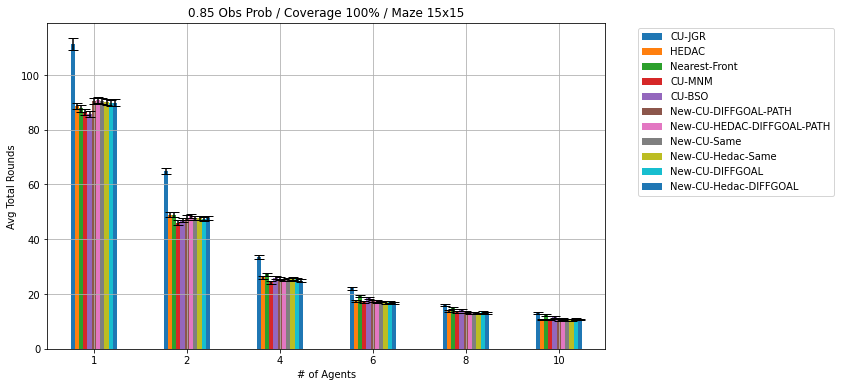

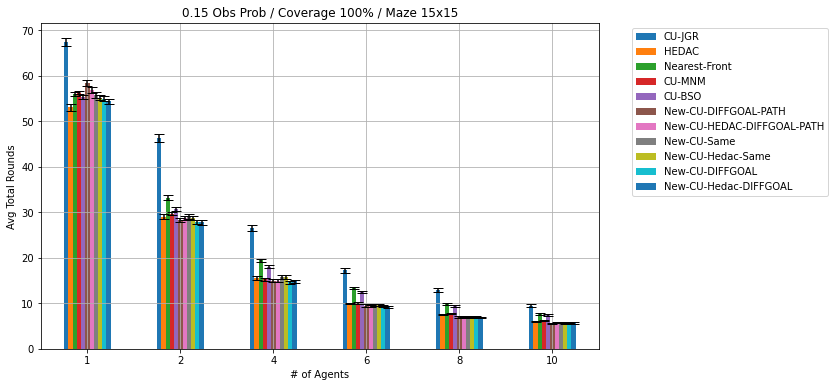

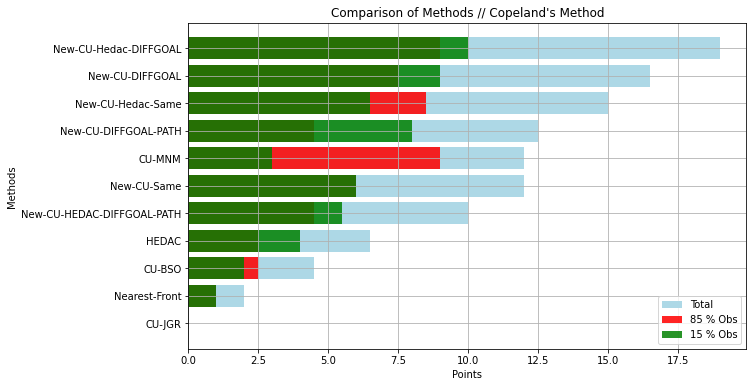

In [11]:
file_dict = {
             'CU-JGR': 'results/cu_jgr/15x15/cu_jgr_15x15_True_2_450.xlsx',
             'HEDAC': 'results/hedac/15x15/hedac_15x15_True_2_450.xlsx', 
             'Nearest-Front': 'results/nf/15x15/nf_15x15_True_2_450.xlsx',
             'CU-MNM': 'results/cu_mnm/15x15/cu_mnm_15x15_True_2_450.xlsx',
             'CU-BSO': 'results/cu_bso/15x15/cu_bso_15x15_True_2_450.xlsx',
             'New-CU-DIFFGOAL-PATH': 'results/new_cu_diffgoal_path/15x15/new_cu_diffgoal_path_15x15_True_2_450.xlsx',
             'New-CU-HEDAC-DIFFGOAL-PATH': 'results/new_cu_hedac_diffgoal_path/15x15/new_cu_hedac_diffgoal_path_15x15_True_2_450.xlsx',
             'New-CU-Same': 'results/new_cu_same/15x15/new_cu_same_15x15_True_2_450.xlsx',
             'New-CU-Hedac-Same': 'results/new_cu_hedac_same/15x15/new_cu_hedac_same_15x15_True_2_450.xlsx',
             'New-CU-DIFFGOAL': 'results/new_cu_diffgoal/15x15/new_cu_diffgoal_15x15_True_2_450.xlsx',
             'New-CU-Hedac-DIFFGOAL': 'results/new_cu_hedac_diffgoal/15x15/new_cu_hedac_diffgoal_15x15_True_2_450.xlsx',
             }
convert_paths_os(file_dict)
plot_comparison(file_dict)
plot_comparison(file_dict, 0.15)

best_85 = select_best(file_dict)
best_15 = select_best(file_dict, 0.15)

best_all = {}
for k in best_85:
    best_all[k] = best_15[k] + best_85[k]

best_all = dict(sorted(best_all.items(), key=lambda item: item[1], reverse=True))

# print(best_15)
# print(best_85)
# print(best_all)
methods = list(best_all.keys())
values_all = list(best_all.values())
values_85 = [best_85[k] for k in best_all]
values_15 = [best_15[k] for k in best_all]

max_value = max(max(values_all), max(values_85), max(values_15))

alpha_85 = 0.3 * (max(values_85) / max_value)
alpha_15 = 0.3 * (max(values_15) / max_value)
plt.figure(figsize=(10, 6))
plt.barh(methods, values_all, color='lightblue', label='Total')
plt.barh(methods, values_85, color='red', label='85 % Obs', alpha=1-alpha_85)
plt.barh(methods, values_15, color='green', label='15 % Obs', alpha=1-alpha_15)
plt.xlabel('Points')
plt.ylabel('Methods')
plt.title("Comparison of Methods // Copeland's Method")
plt.gca().invert_yaxis() # Invert y-axis to have the highest score on top
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<u>Developer Tip:</u> Mean agent step time is just the mean episode time divived by the number of agents.

# Other checks
Here are some other checks for debugging.

Check agent view:

In [ ]:
grid = np.array([[0, 0, 1, 0, 0],
                 [1, 0, 0, 2, 1],
                 [1, 0, 0, 1, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0]])

agents = [Agent((2, 2), (2, 2), grid, 2),]
res = move_astar(grid, agents)


[[ 0 -1  1 -1 -1]
 [-1  0  0  0 -1]
 [ 1  0  0  1 -1]
 [-1  0  1  0 -1]
 [ 0 -1 -1 -1  0]]


In [ ]:

import numpy as np

agent_pos = (0, 1)
total_explored = np.array([[0, 1, 0], [1, -1, -1], [0, -1, -1]])  # Example array
print(total_explored)
n_rows, n_cols = total_explored.shape
x_coords, y_coords = np.meshgrid(np.arange(n_rows), np.arange(n_cols))
distances = np.abs(x_coords - agent_pos[0]) + np.abs(y_coords - agent_pos[1])

print(distances)
# distances[(total_explored != -1)] = max(total_explored.shape) + 1
# indx = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
# print(distances)
# print(indx)
# print(total_explored[indx])


# Mask the non-target cells by setting their distances to a high value
distances[total_explored != -1] = max(total_explored.shape) + 1
print(distances)
# Get the indices that would sort the distances
flat_indices = np.argsort(distances, axis=None)

# Convert flat indices to 2D indices
min_indices = np.unravel_index(flat_indices, distances.shape)

# Convert indices to a list of tuples in the desired order
indx = list(zip(min_indices[0], min_indices[1]))
print(indx)


[[ 0  1  0]
 [ 1 -1 -1]
 [ 0 -1 -1]]
[[1 2 3]
 [0 1 2]
 [1 2 3]]
[[4 4 4]
 [4 1 2]
 [4 2 3]]
[(1, 1), (1, 2), (2, 1), (2, 2), (0, 0), (0, 1), (0, 2), (1, 0), (2, 0)]
[[1 1]
 [1 2]
 [2 0]
 [2 1]
 [2 2]]


array([[2., 3., 2., 3., 4.]])

In [ ]:
grid = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

# grid = create_maze(15, 15)
agents = [Agent((1, 1), (4, 4), grid, 2)]
print(agents[0].explored_stage)
# res = move_nf_coverage(grid, agents, debug=True)
# res = move_hedac_coverage(agents, grid, alpha=10, max_iter=100, debug=False)
# images_to_gif("hedac_improv_idea.gif")
print(f"Average Coverage Percentage {res[0]} / Rounds: {res[1]} / Average Round Time: {res[3]}")
print(f"Final Explored Stage\n{res[2]}")

In [40]:
# Testing cu_jgr unexpl function:
grid = np.array([  [ 1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [ 1,  0,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [ 1,  0,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])


x, y = np.where(grid == 2)
R = 2
print(calculate_utility_jgr(x, y, R, grid) * (np.pi * (R**2)))

16.0


In [3]:
import pandas as pd
# checking creation of copeland method voting matrix with TEST data:

method_dict = { 
            # 1  2  4  6  8  10 agents
    'HEDAC': [1, 2, 3, 2, 3, 4],    # avg total rounds for each number of agents and corresponding method.
    'NEW-C': [3, 1, 4, 9, 8, 7],
    'CU-MN': [4, 3, 1, 6, 5, 4],
    'CU-JR': [2, 2, 2, 3, 2, 1],
}

# basically checks all the elements in one "column" and displays as 1st choice the method with lowest
# integer value, etc.

sorted_keys = list(method_dict.keys())
sorted_keys_list = []
for i in range(len(method_dict[sorted_keys[0]])):
    sorted_keys = sorted(method_dict.keys(), key=lambda x: method_dict[x][i], reverse=False)
    sorted_keys_list.append(sorted_keys)

df = pd.DataFrame(sorted_keys_list, columns=[f'choice_{i+1}' for i in range(len(sorted_keys_list[0]))])
print("Copeland Voting Matrix:")
df

Copeland Voting Matrix:


,choice_1,choice_2,choice_3,choice_4
0,HEDAC,CU-JR,NEW-C,CU-MN
1,NEW-C,HEDAC,CU-JR,CU-MN
2,CU-MN,CU-JR,HEDAC,NEW-C
3,HEDAC,CU-JR,CU-MN,NEW-C
4,CU-JR,HEDAC,CU-MN,NEW-C
5,CU-JR,HEDAC,CU-MN,NEW-C


##### HEDAC Example
We can see that its more likely to go to unexplored cells.

In [ ]:
explored_stage = generate_stage(10, 10)
# puts artificially some unexplored coords:
rep_perc = 0.5
random_indices = np.random.choice(range(explored_stage.size), size=int(explored_stage.shape[0]*explored_stage.shape[1]*rep_perc), replace=False)
explored_stage.flat[random_indices] = -1

u = calc_attractive_field(explored_stage)

aij = np.full_like(u, 0)
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        aij[i, j] = calculate_sum_aij(i, j, explored_stage)

print(aij)

print("Explored Stage:")
print(explored_stage)
draw_maze(explored_stage)
print("White -> unexplored")
print("=================")

print("Final Attraction Field:")
print(u)
draw_maze(u)
print("More black -> more attractive force")
print("=================")


# New Proposed Methods

## Idea 1:
* Maze partion using vorronoi partitioning
* We do cost-utility for each partition
* Once an agent has finished, goes to nearest unfinished partition

Moulinec, H. (2022). A simple and fast algorithm for computing discrete Voronoi, Johnson-Mehl or Laguerre diagrams of points. Advances in Engineering Software, 170, 103150.

Maze:


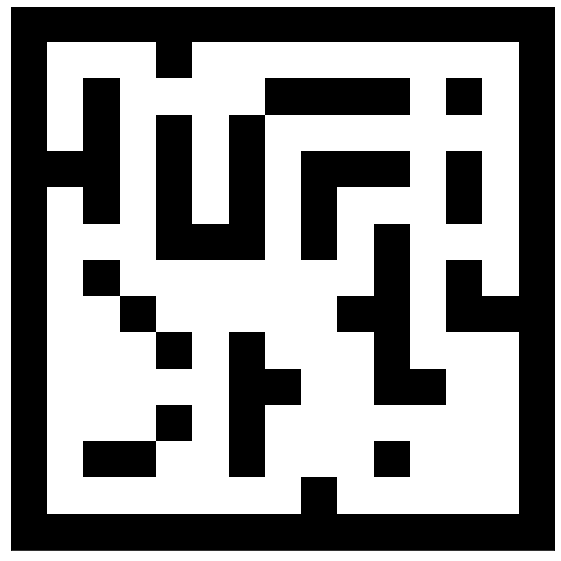

Voronoi:
[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  6.  6.  8.  1.  1.  1.  1.  1.  9.  9.  9.  9.  9. -1.]
 [-1.  0.  0.  1.  1.  1.  1.  1.  1.  9.  9.  9.  9.  9. -1.]
 [-1.  0.  0.  0.  1.  1.  1.  1.  9.  9.  9.  9.  9.  9. -1.]
 [-1.  0.  0.  0.  1.  1.  1.  4.  9.  9.  9.  9.  9.  9. -1.]
 [-1.  0.  0.  0.  1.  3.  3.  4.  4.  9.  9.  9.  9.  9. -1.]
 [-1.  0.  0.  7.  7.  3.  3.  4.  4.  4.  9.  9.  9.  9. -1.]
 [-1.  2.  7.  7.  7.  3.  3.  4.  4.  4.  4.  9.  9.  9. -1.]
 [-1.  2.  7.  7.  7.  3.  3.  4.  4.  4.  4.  4.  4.  4. -1.]
 [-1.  2.  2.  7.  7.  3.  3.  4.  4.  4.  4.  4.  4.  4. -1.]
 [-1.  2.  2.  2.  7.  3.  3.  4.  4.  4.  4.  4.  4.  4. -1.]
 [-1.  2.  2.  2.  7.  3.  3.  4.  4.  4.  4.  4.  4.  4. -1.]
 [-1.  5.  5.  5.  5.  3.  3.  4.  4.  4.  4.  4.  4.  4. -1.]
 [-1.  5.  5.  5.  5.  3.  3.  4.  4.  4.  4.  4.  4.  4. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


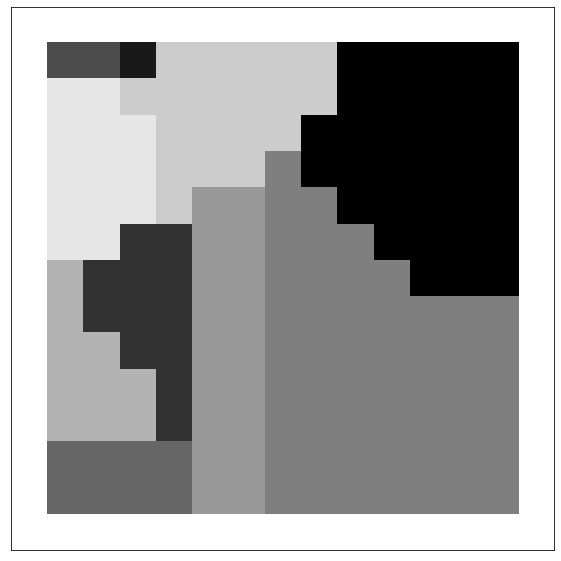

In [26]:
import numpy as np

def voronoi_map(agents):
    D = np.full_like(agents[0].explored_stage, np.inf, dtype=np.float64)
    # I = copy.deepcopy(D)
    I = np.full_like(D, -1)
    for i in range(1, D.shape[0]-1):
        for j in range(1, D.shape[1]-1):
            x_k = (i, j)
            for a_ind, a in enumerate(agents):
                x_s = (a.x, a.y)
                distance = abs(x_s[0] - x_k[0]) + abs(x_s[1] - x_k[1])
                if distance < D[x_k]:
                    I[x_k] = a_ind
                    D[x_k] = distance
    return I

num_agents = 10
agent_view_range = 2
coverage_mode = True

maze = create_maze(15, 15)
print("Maze:")
draw_maze(maze)
agents = generate_agents(real_stage = maze, num_agents = num_agents, view_range = agent_view_range, coverage_mode = coverage_mode)
print("Voronoi:")
v = voronoi_map(agents)
print(v)
draw_maze(v)